In [1]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/decomp.data", 'rb') as filename:
  dataset = pickle.load(filename )

In [2]:
data_dict = []
max_length = 159
for example in dataset:
  instance = {}
  instance['data'] = example[0:-16]  
  seq_len = len(instance['data'])
  pred_arg = example[-16:-14]
  instance['label'] = example[-14:]
  if len(pred_arg) == 2 and isinstance(pred_arg[0], int) and isinstance(pred_arg[1], int):
    instance['data'] = instance['data'] + ["UNK"]*(max_length-seq_len) + pred_arg
    assert len(instance['data']) == 161
    assert len(instance['label']) == 14
    data_dict.append(instance)

In [4]:
import numpy as np
import torch.nn as nn

import torch
from torch.utils.data import Dataset, DataLoader

class DecompDataset(Dataset):
  def __init__(self, data_dictionary):
    self.data = data_dictionary

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [5]:
def my_collate(batch):
  data = [item['data'] for item in batch]
  labels = [torch.Tensor(item['label']) for item in batch]
  labels = torch.stack(labels)
  return [data, labels]

my_batch_size = 10
train_data = DecompDataset(data_dict)
train_data_load = DataLoader(train_data, batch_size=my_batch_size, collate_fn=my_collate)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
#!pip install pytorch-nlp

     |████████████████████████████████| 92kB 9.6MB/s 


In [12]:
from torchnlp.word_to_vector import GloVe
glove = GloVe(name='42B')

glove.42B.300d.zip: 1.88GB [09:54, 3.16MB/s]                           
100%|██████████| 1917494/1917494 [03:54<00:00, 8169.08it/s]


In [62]:
class SPRL_Net(nn.Module):
  def __init__(self):
    super(SPRL_Net, self).__init__()
    self.emb_dim = 300
    self.embedding = glove
    self.encoding = torch.nn.LSTM(input_size=self.emb_dim, hidden_size=25, bidirectional=True)
    self.sharedLinear = torch.nn.Linear(in_features=100, out_features=20)
    self.ReLu = torch.nn.ReLU()
    self.LinearList = [torch.nn.Linear(in_features=20, out_features=1) for i in range(14)]

  def forward(self, x):
    # Double check the dimension on this embedding layer
    embeddings = np.zeros((max_length, len(x), self.emb_dim), dtype=np.float32)
    for i in range(max_length):
      for j in range(len(x)):
        embeddings[i][j] = torch.Tensor(self.embedding[x[j][i]])
    embedding = torch.from_numpy(embeddings).to(device)
    assert embedding.shape == torch.Size([max_length,len(x), self.emb_dim])

    assert embedding.is_cuda
    encoded, (_,_) = self.encoding(embedding)
    assert encoded.is_cuda
    pred_arg_vectors = []
    for i in range(len(x)):
      pred = x[i][-2]-1
      arg = x[i][-1]-1
      pred_arg_vectors.append(torch.cat([encoded[pred][i], encoded[arg][i]]))
    pred_arg_vectors = torch.stack(pred_arg_vectors)
    shared = self.ReLu(self.sharedLinear(pred_arg_vectors))
    assert shared.is_cuda
    out = []
    for i in range(len(x)):
      attributes = []
      for lin in self.LinearList:
        lin.to(device)
        attributes.append(lin(shared[i]))
      out.append(torch.stack(attributes))

    return torch.stack(out).to(device)


net = SPRL_Net()
net.to(device)
learning_rate = .01
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)


In [68]:
import time
num_epochs = 50
loss_fn = torch.nn.MSELoss()
train_epoch_losses = []

print("Starting Training")
#training loop:
for epoch in range(num_epochs):
  time1 = time.time() #timekeeping

  loss_sum = 0
  total = 0
  for i, example in enumerate(train_data_load):
      data = example[0]
      labels = torch.Tensor(example[1]).to(device)

      total+=1
    
    #loss calculation and gradient update:
      if i > 0 or epoch > 0:
        optimizer.zero_grad()
      shape = (len(data),14)
      outputs = torch.reshape(net(data), shape)
      assert outputs.is_cuda
 
      loss_list = torch.stack([loss_fn(outputs[:,i], labels[:,i]) for i in range(14)])
      loss = torch.sum(loss_list)
      loss.backward()
      loss_sum+=loss
      

      ##performing update:
      optimizer.step() 
  epoch_loss = loss_sum.cpu().data.numpy().item() / total
  train_epoch_losses.append(epoch_loss)

  print("Epoch",epoch+1,':')
  # Training loss
  print('Train loss: %f' % (epoch_loss))
  time2 = time.time() #timekeeping
  print('Elapsed time for epoch:',time2 - time1,'s')
  print('ETA of completion:',(time2 - time1)*(num_epochs - epoch - 1)/60,'minutes')
  print()


Starting Training
Epoch 1 :
Train loss: 4.505780
Elapsed time for epoch: 29.224403858184814 s
ETA of completion: 23.866596484184264 minutes

Epoch 2 :
Train loss: 4.470093
Elapsed time for epoch: 29.032420873641968 s
ETA of completion: 23.225936698913575 minutes

Epoch 3 :
Train loss: 4.457707
Elapsed time for epoch: 29.261125802993774 s
ETA of completion: 22.921215212345125 minutes

Epoch 4 :
Train loss: 4.451741
Elapsed time for epoch: 29.072443962097168 s
ETA of completion: 22.288873704274497 minutes

Epoch 5 :
Train loss: 4.444914
Elapsed time for epoch: 29.07900047302246 s
ETA of completion: 21.809250354766846 minutes

Epoch 6 :
Train loss: 4.438275
Elapsed time for epoch: 29.171323537826538 s
ETA of completion: 21.392303927739462 minutes

Epoch 7 :
Train loss: 4.441746
Elapsed time for epoch: 29.057637929916382 s
ETA of completion: 20.824640516440073 minutes

Epoch 8 :
Train loss: 4.433056
Elapsed time for epoch: 29.057982206344604 s
ETA of completion: 20.340587544441224 minutes


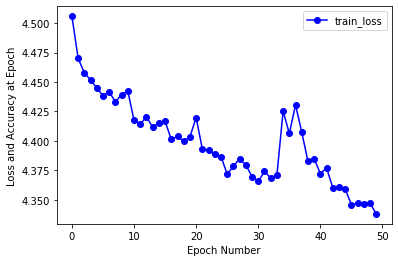

In [69]:
import matplotlib.pyplot as plt

## Plotting batch-wise train loss curve:
plt.plot(train_epoch_losses, '-o', label = 'train_loss', color = 'blue')
plt.xlabel('Epoch Number')
plt.ylabel('Loss and Accuracy at Epoch')
plt.legend()
plt.show()

In [71]:
torch.save(net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model_weights')